In [1]:
%matplotlib notebook
import os, sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.distributions as torchD

import torch, seaborn as sns
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from utils import *
from AE_collection import *

import ipywidgets as widgets
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

## Load Dataset

In [2]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [3]:
batch_size = 128

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../data/", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root="../data/", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = [1, 28, 28]
enc_dim = 400
latent_dim = 2
num_epochs = 50
logDir = "models_and_stats/"

## Load models

In [5]:
model_names = ["MLP_AE_l2", "MLP_VAE_dist_l2_wkl_10_wr_1", "MLP_VAE_dist_l2_wkl_10_wr_0", "MLP_CVAE_dist_l2_wkl_10_wr_1"]
short_names = ["recon only (AE)", "recon + kl", "kl only", "CVAE"]
model1 = MLP_AE(input_shape=input_shape, latent_dim=latent_dim)
model2 = MLP_VAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim)
model3 = MLP_VAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim)
model4 = MLP_CVAE(input_shape=input_shape, enc_dim=enc_dim, latent_dim=latent_dim)
models = [model1, model2, model3, model4]
results_dicts = []
for i in range(len(models)):
    print("loading model for {}".format(model_names[i]))
    model = models[i]
    model_path = logDir + model_names[i] + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    dict_name = model_names[i] + '.pkl'
    results_dicts.append(pickle.load(open(logDir + dict_name, 'rb'))) 

loading model for MLP_AE_l2
loading model for MLP_VAE_dist_l2_wkl_10_wr_1
loading model for MLP_VAE_dist_l2_wkl_10_wr_0
loading model for MLP_CVAE_dist_l2_wkl_10_wr_1


### 1. compare latent space

In [6]:
# plot the whole test latent space
all_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)
all_test_imgs, all_test_labels = next(iter(all_test_loader))
all_test_imgs, all_test_labels = torch.tensor(all_test_imgs).float().to(device), torch.tensor(all_test_labels).to(device)

In [7]:
all_test_latents_list = []
all_test_latent_means_list = []
all_test_latent_logvars_list = []
for i in range(len(models)):
    model = models[i]
    if i == 0: # AE
        all_test_latents, all_test_reconstructions = model(all_test_imgs)
    elif i == 3: # CVAE
        all_test_latents, all_test_reconstructions, all_test_latent_means, all_test_latent_logvars = model(all_test_imgs, all_test_labels)
    else: # VAE
        all_test_latents, all_test_reconstructions, all_test_latent_means, all_test_latent_logvars = model(all_test_imgs)
    all_test_latents_list.append(all_test_latents)
    if i != 0 :
        all_test_latent_means_list.append(all_test_latent_means)
        all_test_latent_logvars_list.append(all_test_latent_logvars)

In [8]:
idx =  0 # AE
model = models[idx]
# print(model)
test_latents = all_test_latents_list[idx].cpu().detach().numpy()
test_labels = all_test_labels.cpu().detach().numpy()
print("test_latents shape", test_latents.shape)

z0_min, z0_max = test_latents[:,0].min(), test_latents[:,0].max()
z1_min, z1_max = test_latents[:,1].min(), test_latents[:,1].max()
print("test z0_min {}, z0_max {}, z2_min {}, z1_max {}".format(z0_min, z0_max, z1_min, z1_max))

test_latents shape (10000, 2)
test z0_min -4.5828142166137695, z0_max 61.697940826416016, z2_min -23.611064910888672, z1_max 17.014328002929688


<IPython.core.display.Javascript object>


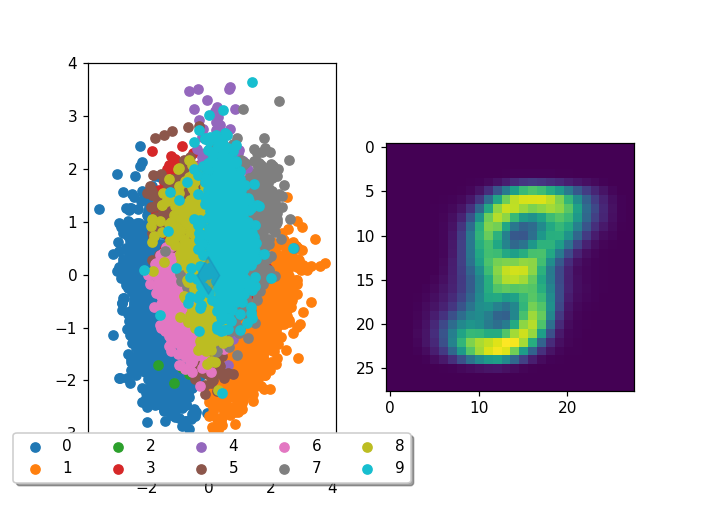

interactive(children=(FloatSlider(value=0.0, description='z0', max=3.127901315689087, min=-2.942139148712158),…

In [14]:
fig, ax = plt.subplots(1, 2)
# plot the whole latent space as the background in ax[0]
for y in np.unique(test_labels):
    i = np.where(test_labels == y)
    ax[0].scatter(test_latents[i,0], test_latents[i,1], label=y, cmap="tab10")
    ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
# initiate a test point
z0 = 0.
z1 = 0.
latent_vector = np.array([[z0, z1]])
latent_vector = torch.from_numpy(latent_vector).float().to(device)
decoded_img = model.decoder(latent_vector)
decoded_img = decoded_img.cpu().detach().numpy()[0][0] 
pt = ax[0].scatter(z0, z1, s=300, marker='d', label="test pt", alpha=0.3)
ax[1].imshow(decoded_img)


def update(z0=0.0, z1=0.0):
    
    latent_vector = np.array([[z0, z1]])
    latent_vector = torch.from_numpy(latent_vector).float().to(device)
    decoded_img = model.decoder(latent_vector)
    decoded_img = decoded_img.cpu().detach().numpy()[0][0] 
    pt.set_offsets(np.c_[z0, z1])
    ax[1].imshow(decoded_img)

    fig.canvas.draw_idle()
    fig.canvas.flush_events()

widgets.interact(update, z0=(z0_min, z0_max), z1=(z1_min, z1_max));

In [15]:
idx =  1 # VAE
model = models[idx]

test_latents = all_test_latents_list[idx].cpu().detach().numpy()
test_labels = all_test_labels.cpu().detach().numpy()
print("test_latents shape", test_latents.shape)

test_latent_means = all_test_latent_means_list[idx-1].cpu().detach().numpy()
test_latent_logvars = all_test_latent_logvars_list[idx-1].cpu().detach().numpy()

z0_min, z0_max = test_latent_means[:,0].min(), test_latent_means[:,0].max()
z1_min, z1_max = test_latent_means[:,1].min(), test_latent_means[:,1].max()
logvar_z0_min, logvar_z0_max = test_latent_logvars[:,0].min(), test_latent_logvars[:,0].max()
logvar_z1_min, logvar_z1_max = test_latent_logvars[:,1].min(), test_latent_logvars[:,1].max()
print("test z0_min {}, z0_max {}, z2_min {}, z1_max {} \n logvar_z0_min {}, logvar_z0_max {}, logvar_z1_min {}, logvar_z1_max {}".format(z0_min, z0_max, z1_min, z1_max, logvar_z0_min, logvar_z0_max, logvar_z1_min, logvar_z1_max))

test_latents shape (10000, 2)
test z0_min -2.942139148712158, z0_max 3.127901315689087, z2_min -2.7299132347106934, z1_max 3.7830419540405273 
 logvar_z0_min -4.96877908706665, logvar_z0_max -0.2552180886268616, logvar_z1_min -4.453423023223877, logvar_z1_max -0.3617098331451416


In [16]:
def get_correlated_dataset(n, dependency, mu, scale):
    print("mu {}, dependency {}, scale {}".format(mu.shape, dependency.shape, scale.shape))
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    print("scaled_with_offset", scaled_with_offset.shape)

    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]


def get_ellipse_param(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    ref: https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    """
    
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    
    transform = transf + ax.transData
    
    return ellipse.get_center(), ellipse.get_width(), ellipse.get_height(), ellipse.get_angle(), transform

<IPython.core.display.Javascript object>


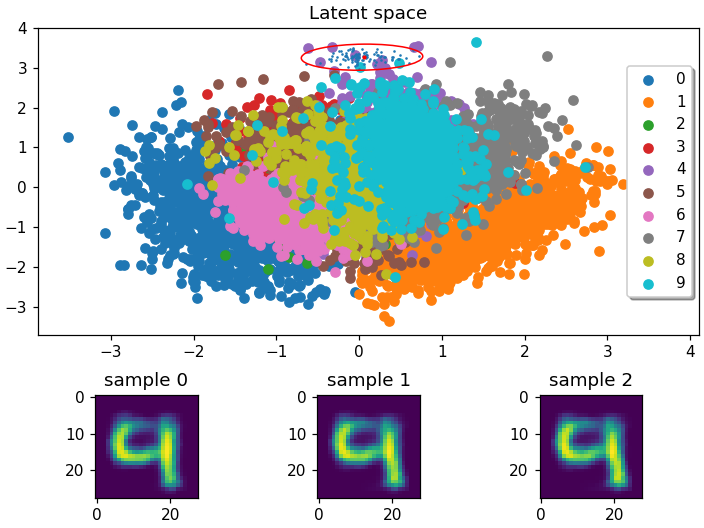

mu (2,), dependency (2, 2), scale (2,)
scaled_with_offset (100, 2)


interactive(children=(FloatSlider(value=0.0, description='z0_mean', max=3.127901315689087, min=-2.942139148712…

In [17]:
N_sample = 3

# create figure and gridspec
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(4, 3)
f3_ax1 = fig3.add_subplot(gs[:3, :])
f3_ax1.set_title("Latent space")
f3_ax2 = fig3.add_subplot(gs[3, 0])
f3_ax3 = fig3.add_subplot(gs[3, 1])
f3_ax4 = fig3.add_subplot(gs[3, 2])
im_axes = [f3_ax2, f3_ax3, f3_ax4]
im_titles = ["sample {}".format(i) for i in range(len(im_axes))]
for im_ax, im_title in zip(im_axes, im_titles):
    im_ax.set_title(im_title)

    
# plot the whole latent space as the background in ax[0]
for y in np.unique(test_labels):
    i = np.where(test_labels == y)
    f3_ax1.scatter(test_latents[i,0], test_latents[i,1], label=y, cmap="tab10")
    f3_ax1.legend(loc="center right",fancybox=True, shadow=True) # , ncol=5
# initiate testing points
# for VAE, give mean and logvar, draw a circle and sample several times
z0_mean = 0.
z1_mean = 0.
z0_logvar = 0.
z1_logvar = 0.


latent_mean = np.array([[z0_mean, z1_mean]])
latent_logvar = np.array([[z0_logvar, z1_logvar]])
# plot sampling and confidence ellipse
mean = np.array([z0_mean, z1_mean])
logvar = np.array([z0_logvar, z1_logvar])
scale = np.exp(0.5*logvar)
dependency = np.array([[1, 0],[0, 1]])
x, y = get_correlated_dataset(100, dependency, mean, scale)
scatter_pt = f3_ax1.scatter(x, y, s=0.5)
# initiate ellipse object
center, width, height, angle, transform = get_ellipse_param(x, y,f3_ax1) #confidence_ellipse(x, y, f3_ax1, edgecolor='red')
ellipse = Ellipse(center, width=width, height=height, angle=angle, transform=transform, facecolor="none", edgecolor='red')
f3_ax1.add_patch(ellipse)

pt = f3_ax1.scatter(mean[0], mean[1], c='red', s=3)

# plot reconstructed image
latent_mean, latent_logvar = torch.from_numpy(np.expand_dims(mean, axis=0)).float().to(device), torch.from_numpy(np.expand_dims(logvar, axis=0)).float().to(device)
for i in range(N_sample):
    latent_vector = model.reparameterize(latent_mean, latent_logvar)
    decoded_img = model.decoder(latent_vector)
    decoded_img = decoded_img.cpu().detach().numpy()[0][0] 
    im_axes[i].imshow(decoded_img)

def update(z0_mean=0.0, z1_mean=0.0, z0_logvar=0.0, z1_logvar=0.0):
    
    latent_mean = np.array([[z0_mean, z1_mean]])
    latent_logvar = np.array([[z0_logvar, z1_logvar]])
    # plot sampling and confidence ellipse
    mean = np.array([z0_mean, z1_mean])
    logvar = np.array([z0_logvar, z1_logvar])
    scale = np.exp(0.5*logvar)
    dependency = np.array([[1, 0],[0, 1]])
    x, y = get_correlated_dataset(100, dependency, mean, scale)
    scatter_pt.set_offsets(np.c_[x,y])
    pt.set_offsets(np.c_[mean[0], mean[1]])
    
    # update ellipse
    center, width, height, angle, transform = get_ellipse_param(x,y,f3_ax1)
    ellipse.set_center(center)
    ellipse.set_angle(angle)
    ellipse.set_height(height)
    ellipse.set_width(width)
    ellipse.set_transform(transform)

    # plot reconstructed image
    latent_mean, latent_logvar = torch.from_numpy(np.expand_dims(mean, axis=0)).float().to(device), torch.from_numpy(np.expand_dims(logvar, axis=0)).float().to(device)
    for i in range(N_sample):
        latent_vector = model.reparameterize(latent_mean, latent_logvar)
        decoded_img = model.decoder(latent_vector)
        decoded_img = decoded_img.cpu().detach().numpy()[0][0] 
        im_axes[i].imshow(decoded_img)
    
    fig3.canvas.draw_idle()
    fig3.canvas.flush_events()

widgets.interact(update, z0_mean=(z0_min, z0_max), z1_mean=(z1_min, z1_max), z0_logvar=(logvar_z0_min, logvar_z0_max), z1_logvar=(logvar_z1_min, logvar_z1_max));